Code to build a basic soil water budget model based on the mathematical equations used by IDC with simplification as here the key is identifying percolation rather than applied water.

In [14]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import glob
import sys
import time

import pandas as pd
import numpy as np

import h5py
from scipy.io import loadmat

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import shapely
import geopandas as gpd



In [15]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
dis_dir = join(gwfm_dir, 'DIS_data')
uzf_dir = join(gwfm_dir,'UZF_data')

In [121]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
# other functions
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')
add_path(py_dir)

# from mf_utility import get_layer_from_elev
from swb_utility import calc_S, calc_pc
# from swb_utility import prep_soil

## Hydrologic data

In [18]:
# strt_date = pd.to_datetime('2014-10-1')
strt_date = pd.to_datetime('1998-10-1')
end_date = pd.to_datetime('2020-12-31')
dates = pd.date_range(strt_date, end_date)
nper = len(dates)

nrow, ncol = (100,230)


In [19]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'CIMIS','Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']

# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000
# fill in missing days of rain with zero values
rain_df = rain_m.reindex(dates)
rain_df[rain_df.isna()]=0
# convert to array for calculations
rain = rain_df['Fair Oaks'].values


In [20]:
# load in pre-processed array of ETc for all time
ETc_long = pd.read_hdf(join(uzf_dir, "dwr_ETc",'long_ETc_all_lu.hdf5'), key='variable')
# convert to column format
ETc_all = ETc_long.pivot(columns='variable', values='value')

# subset for model period
ETc_all = ETc_all[strt_date:end_date]
# fill in empty dates with interpolation (temporary since corn dates are slightly different)
ETc_all = ETc_all.reindex(dates)


# Spatial data
The land use data doesn't specify water source for most, listed as * so missing.

In [72]:
ag_lu = gpd.read_file(join(uzf_dir,'county_landuse', 'domain_ag_lu_2018.shp'))
# 5 duplicates in irrigation efficiency
ag_irr_eff = ag_lu[['geom_id', 'name', 'irr_name', 'Avg_eff']].drop_duplicates()

In [88]:
# load cleaned soil data for ag fields
soil_path = join(uzf_dir,'clean_soil_data')
# soil data for each ag field
soil_ag = pd.read_csv(join(soil_path, 'soil_for_ag_fields.csv'), index_col=0)
# connection of ag fields to grid cells
# grid_soil = pd.read_csv(join(soil_path, 'ag_field_to_cell.csv'),index_col=0)
# # curve numbers, have duplicates but okay to drop since  identical
CN = pd.read_csv(join(soil_path, 'ag_field_CN.csv'),index_col = 0).drop_duplicates(keep='first')
soil_ag = pd.merge(soil_ag, CN, how='left', on=['geom_id','name','irr_name'])
# # # irrigation efficiency
soil_ag = soil_ag.merge(ag_irr_eff, how='left')
# create irrigation efficiency multiplier to have 0 applied water for non-irrgated
soil_ag['irr_eff_mult'] = 100/soil_ag.Avg_eff
soil_ag.loc[soil_ag.irr_eff_mult.isna(), 'irr_eff_mult'] = 0


In [90]:
# I would keep these fields but still don't have a way to account for fallow/bare soil
drop_fields = ['new lands being prepared for crop production', 
               'Land not cropped the current or previous crop season, but cropped within the past three years',
               'Mixed (four or more)']

soil_ag = soil_ag[~soil_ag.name.isin(drop_fields)]

# calculate areas
field_area = soil_ag.field_area_m2.values
nfield = len(soil_ag)

# reference for cells with agriculture which have slightly different rules
ag_arr = (soil_ag.irr_name != 'no irrig').values

In [91]:
soil_ag.to_csv(join(soil_path, 'fields_output_reference.csv'), index=False)

## Solver for all unique soil/crop fields at once

In [94]:
def prep_soil(soil_ag):
    global soil_Ks, soil_por, soil_eps, soil_CN
    global soildepth, soil_m, wc_f, wc_wp, Smax
    global irr_eff_mult
    # # when soil_K_low is missing using a substitute of Ksat/10
    soil_Ks = np.where(soil_ag.Ksat_Low==0, soil_ag.Ksat/10, soil_ag.Ksat_Low)
    soil_por = soil_ag.Porosity.values/100
    soil_eps = soil_ag.EPS.values
    soil_CN = soil_ag.CN.values
#     irr_eff = soil_ag.Avg_eff.values/100
    irr_eff_mult = soil_ag.irr_eff_mult.values
    
    soildepth = soil_ag.SoilDepth.values
    psdi =  soil_ag.PSDI.values
    # parameter for Mualem, van Genuchten
    soil_m = psdi/(psdi+1)
    wc_f =  soil_ag.w3rdbar.values/100 #field capacity
    wc_wp =  soil_ag.w15bar.values/100 #wilting point 

    # Calculate total available water in the root zone
    taw = (wc_f - wc_wp)*soildepth 

    # for runoff, convert CN from fraction to CN
    Smax = (1000/soil_CN) - 10

prep_soil(soil_ag)



In [95]:
# def calc_S(wc, Smax, wc_f, soil_por):
#     """ Given an array of water contents return potential soil retention"""
#     S = np.zeros(Smax.shape)
#     # when water content is less than 1/2 field capacity, full retention
#     S[wc < wc_f/2] = Smax[wc < wc_f/2]
#     # wc > porosity then set as porosity for calculations (avoids S >1)
#     wc_calc = np.where(wc<soil_por, wc, soil_por)
#     # when water content is greater than 1/2 field capacity, partial retention 
#     S1 = Smax * (1 - ((wc_calc - wc_f/2)/(soil_por - wc_f/2)))
#     S[wc >= wc_f/2]= S1[wc >= wc_f/2]
#     # convert S from inches to meters
#     S *= (0.3048/12)
#     return(S)

In [97]:
# pull out the crop ET for the fields simulated
# it may be necessary to add ET in the winter months representing bare soil ET?
ETc = ETc_all.loc[:,soil_ag.name.values].values
ETc[np.isnan(ETc)] = 0



# Run the model
The ETc, and rain will be preset inputs for the irrigation simulation (the ETc will be calculated when the crop is chosen at the start of the year).  
The irrigation optimizer will be a function of crop - ETc, irrigation (variable calibrated)

In [111]:
# def calc_pc(wc, soil_por, soil_Ks, soil_m):
#     """ explicit calculation of percolation assuming water content of prior to 
#     percolation is representative of conditions controlling percolation"""
#     # calculate soil saturation as water content can be greater than porosity assuming it represents ponding
#     sat = wc/soil_por
#     sat  = np.where(sat>1, 1, sat)
#     # explicit calculation of percolation
#     pc = soil_Ks*(sat)*(1- (1-(sat)**(1/soil_m))**soil_m)**2
#     return(pc)

# # calc_pc(wc[0], soil_por, soil_Ks, soil_m)

array([1.15513677e-04, 1.15513677e-04, 1.15513677e-04, ...,
       9.97840461e-06, 9.59383126e-08, 6.95809229e-05])

In [124]:
def swb():
    global wc, pc, rp, ETa, AW

    tic = time.time()
    
    wc = np.zeros((nper+1, nfield)) # water content, add initial conditions with +1
    pc = np.zeros((nper, nfield)) # percolation
    rp = np.zeros((nper, nfield)) # runoff 
    ETa = np.zeros((nper, nfield)) # actual ET
    AW = np.zeros((nper, nfield)) # applied water
    wb_sum= np.zeros((nper, nfield)) # water budget check
    # time units are days for everything
    
    # WC starts at field content for ag fields and wilting point for non ag
    wc[0] = wc_wp
    wc[0, ag_arr] = wc_f[ag_arr]
#     n is for BC, ns is for storage
    # -1 starts at IC for BC
    for ns, n in enumerate(np.arange(-1, nper-1)):
        # calculate soil saturation as water content can be greater than porosity assuming it represents ponding
#         sat = wc[ns]/soil_por
#         sat  = np.where(sat>1, 1, sat)
        ## Runoff ##
        S = calc_S(wc[ns], Smax, wc_f, soil_por)
        water_in = rain[n+1] 
        # calculate runoff only when there is rain, and rain is uniform
        if (water_in>0).any():
            rp[n+1] = ((water_in - 0.2*S)**2)/(water_in + 0.8*S)
        # where rainfall is less than initial abstraction (0.2S) set runoff as 0
        rp[n+1] = np.where(water_in<0.2*S, 0, rp[n+1])
        ## explicit percolation ##
#         pc[n+1] = soil_Ks*(sat)*(1- (1-(sat)**(1/soil_m))**soil_m)**2
        pc[n+1] = calc_pc(wc[ns], soil_por, soil_Ks, soil_m)
        # stepwise water budget, explicit to avoid iteration
        # add rain and take away runoff first
        wc[ns+1] = (wc[ns]*soildepth + (water_in - rp[n+1]))/soildepth
        # add irrigation with the assumption it is designed to limit runoff
        AW[n+1] = ETc[n+1]*irr_eff_mult
#         AW[n+1] = 0
        wc[ns+1] = wc[ns+1] + AW[n+1]/soildepth
        # take away ET, add term to prevent going to zero
        ET = ETc[n+1] # ET will be from crops or bare soil (off season)
        ETa[n+1] = np.where(ET <= wc[ns+1]*soildepth, ET, wc[ns+1]*soildepth - 1E-9)
        wc[ns+1] = wc[ns+1] + (-ETa[n+1])/soildepth
        # take away percolation
        pc[n+1] = np.where(pc[n+1] <= wc[ns+1]*soildepth, pc[n+1], wc[ns+1]*soildepth - 1E-9)
        wc[ns+1] = wc[ns+1] + (-pc[n+1])/soildepth
        # check water budget error
        wb_sum[n+1] = (wc[ns]-wc[ns+1])*soildepth + water_in + AW[n+1] - rp[n+1] - ETa[n+1] - pc[n+1] 
        if (wb_sum[n+1]>1E-3).any()|(wb_sum[n+1]<-1E-3).any():
            print('WB error exceeds 1E-3',n )
            
    toc = time.time()
    print('Run time was %.2f minutes' %((toc-tic)/60))
    print('Avg WB error was %.2E m' % wb_sum.sum(axis=(1)).mean())

In [125]:
swb()

Run time was 0.08 minutes
Avg WB error was 3.24E-15 m


In [126]:
pc.sum()

23306.433465582828

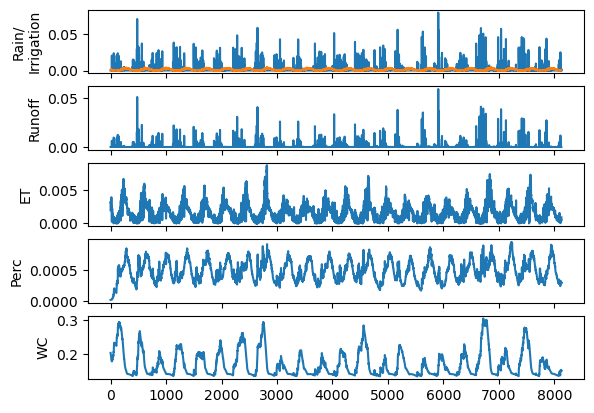

In [102]:
fig,ax = plt.subplots(5,1,sharex=True)
ax[0].plot(rain)
ax[0].plot(AW.mean(axis=(1)))
ax[1].plot(rp.mean(axis=(1)))
ax[2].plot(ETa.mean(axis=(1)))
ax[3].plot(pc.mean(axis=(1)))
ax[4].plot(wc.mean(axis=(1)))

for n, l in enumerate(['Rain/\nIrrigation','Runoff','ET','Perc','WC']):
    ax[n].set_ylabel(l)
# ax[0].legend()

## Convert percolation to cells from fields

In [147]:
grid_soil = pd.read_csv(join(soil_path, 'ag_field_to_cell.csv'))
pc_arr = np.zeros((pc.shape[0], nrow,ncol))

In [156]:
t0 = time.time()
# pretty inefficient loop, but only takes 45ish seconds
for n in np.arange(0, len(soil_ag)):
    soil_line = soil_ag.iloc[[n]]
    # identify the field to focus on
    grid_line = grid_soil.merge(soil_line)
    # iterate over the grid cells to apply
    for c in np.arange(0,len(grid_line)):
        # scale the percolation rate by the fraction of the cell covered by the field
        scale_pc = pc[:, n]*grid_line.iloc[c].cell_field_area_m2/(200*200)
        pc_arr[:, grid_line.iloc[c].row-1, grid_line.iloc[c].column-1] = scale_pc
t1 = time.time()
print(((t1-t0)/60))

0.7923046469688415


In [ ]:
# the potential issue I'm seeing witht he new soil budget is that none of the foothills are receiving any recharge

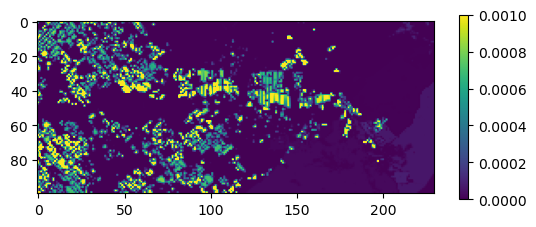

In [168]:
plt.imshow(pc_arr[-720:].mean(axis=0), vmax=1e-3)
plt.colorbar(shrink=0.5)
# the field based version of recharge is cool because you can see the lines between fields of roads
# if you set vmax to 1E-4 in/day you start to see some recharge in the foothills but it is on the order of 1E-5 to 5E-5
# the recharge due to rainfall now seems very small, I should check if any soil paramter CN, changed significantly

## Save Output

In [103]:

import h5py

def arr_to_h5(arr, h5_fn):
    # convert arrays of annual rates to hdf5 files individually
    with h5py.File(h5_fn, "w") as f:
        grp = f.require_group('array') # makes sure group exists
        grp.attrs['units'] = 'meters/day'
        grp.attrs['description'] = 'Each row of the dataframe is a day in the water year'
        dset = grp.require_dataset('WY', arr.shape, dtype='f', compression="gzip", compression_opts=4)
        dset[:] = arr
#     f.close()
    


In [104]:
# years and array index 
years = pd.date_range(strt_date,end_date,freq='AS-Oct')
yr_ind = (years-strt_date).days


In [161]:
pc_arr.shape

(8128, 100, 230)

In [159]:

# need separte hdf5 for each year because total is 300MB
for n in np.arange(0,len(yr_ind)-1):
#     arr = pc[yr_ind[n]:yr_ind[n+1]]
    arr = pc_arr[yr_ind[n]:yr_ind[n+1]]
    fn = join(uzf_dir,'basic_soil_budget', "field_percolation_WY"+str(years[n].year+1)+".hdf5")
    arr_to_h5(arr, fn)

    # applied water 
    arr = AW[yr_ind[n]:yr_ind[n+1]]
    fn = join(uzf_dir, 'basic_soil_budget',"field_applied_water_WY"+str(years[n].year+1)+".hdf5")
    arr_to_h5(arr, fn)

## Review precip vs percolation

In [45]:
chk = pc.sum(axis=(1,2))*200*200/((0.3048**3)*43560)
chk1 = rain_arr.sum(axis=(1,2))*200*200/((0.3048**3)*43560)

for n in np.arange(0,len(yr_ind)-1):
    print('Perc %.2e'%(chk[yr_ind[n]:yr_ind[n+1]]).sum(), end=', ')
    print('Rain %.2E' %(chk1[yr_ind[n]:yr_ind[n+1]].sum()), end=', ')
    print('Frac %.2f'%(chk[yr_ind[n]:yr_ind[n+1]].sum()/chk1[yr_ind[n]:yr_ind[n+1]].sum()))


Perc 2.70e+04, Rain 3.39E+05, Frac 0.08
Perc 1.60e+05, Rain 4.83E+05, Frac 0.33
Perc 9.60e+04, Rain 3.07E+05, Frac 0.31
Perc 7.89e+04, Rain 3.71E+05, Frac 0.21
Perc 7.65e+04, Rain 3.59E+05, Frac 0.21
Perc 7.56e+04, Rain 3.07E+05, Frac 0.25
Perc 1.30e+05, Rain 4.87E+05, Frac 0.27
Perc 1.64e+05, Rain 5.08E+05, Frac 0.32
Perc 4.96e+04, Rain 2.62E+05, Frac 0.19
Perc 5.08e+04, Rain 2.40E+05, Frac 0.21
Perc 5.69e+04, Rain 3.12E+05, Frac 0.18
Perc 7.73e+04, Rain 3.58E+05, Frac 0.22
Perc 1.58e+05, Rain 5.38E+05, Frac 0.29
Perc 6.39e+04, Rain 3.13E+05, Frac 0.20
Perc 6.77e+04, Rain 2.94E+05, Frac 0.23
Perc 4.37e+04, Rain 2.92E+05, Frac 0.15
Perc 5.19e+04, Rain 2.87E+05, Frac 0.18
Perc 6.59e+04, Rain 3.25E+05, Frac 0.20
Perc 2.22e+05, Rain 7.01E+05, Frac 0.32
Perc 8.53e+04, Rain 4.50E+05, Frac 0.19
Perc 1.62e+05, Rain 5.76E+05, Frac 0.28
Perc 5.36e+04, Rain 3.01E+05, Frac 0.18
